# Importing Modules

The necessary modules are : os, opencv, numpy, tqdm, matplotlib, keras and sklearn

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pdb
# from keras2onnx import convert_keras
%matplotlib inline

Using TensorFlow backend.


In [3]:
import keras

In [4]:
# check if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14036895851325231397
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14879450727
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15689246419990597890
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

# Constructing Training and Test Datasets

## Loading the Images

We first load all the images and the corresponding segmentation masks. 

They are stored in two lists X, Y and respectively

Moreover, the images are resized to 256x192

In [5]:
X = []
Y = []
n_classes = 2
 
for scan_dir in ['scan1','scan2','scan3','scan4','scan5']:
    image_idx = 0

    img_dir = "E:\JZY\Other Labeling\{}".format(scan_dir)
    label_dir = "E:\JZY\Other Labeling\{}\LabelingProject\GroundTruthProject\PixelLabelData".format(scan_dir)

    img_files = next(os.walk(img_dir))[2]
    msk_files = next(os.walk(label_dir))[2]

    img_files.sort()
    msk_files.sort()

    print(len(img_files))
    print(len(msk_files))

    for img_fl in tqdm(img_files):    
        if(img_fl.split('.')[-1]=='png'):
            image_idx += 1

            img = cv2.imread('{}\{}'.format(img_dir,img_fl), cv2.IMREAD_GRAYSCALE)
            print('{}\{}'.format(img_dir,img_fl))
            

    #         print('E:\YKL\Thorlabs VSCAN Labeling\scan30\{}'.format(img_fl))
            resized_img = cv2.equalizeHist(np.clip(cv2.resize(img,(128, 96), interpolation = cv2.INTER_NEAREST),0,255))
            resized_denoised_img = cv2.fastNlMeansDenoising(resized_img,10,7,21)

            X.append(resized_denoised_img)

            print('{}\Label_{}_{}'.format(label_dir,image_idx,img_fl.split('.')[0]+'.png'))
            msk = cv2.imread('{}\Label_{}_{}'.format(label_dir,image_idx,img_fl.split('.')[0]+'.png'), cv2.IMREAD_GRAYSCALE)
            resized_msk = np.clip(cv2.resize(msk,(128, 96), interpolation = cv2.INTER_NEAREST),0,n_classes-1) # class lables 0, ..., n-1

            # additional post processing for one hot encoding mask
            resized_msk[resized_msk==0] = n_classes+1 # none are labelled zero
            resized_msk_one_hot = np.zeros((resized_msk.shape[0], resized_msk.shape[1], n_classes))
            for i, unique_value in enumerate(np.unique(resized_msk)):
                resized_msk_one_hot[:, :, i][resized_msk == unique_value] = 1

            Y.append(resized_msk_one_hot)
        

9
9


  0%|          | 0/9 [00:00<?, ?it/s]

E:\JZY\Other Labeling\scan1\01.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_01.png


 11%|█         | 1/9 [00:00<00:01,  5.68it/s]

E:\JZY\Other Labeling\scan1\02.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_2_02.png


 22%|██▏       | 2/9 [00:00<00:01,  5.99it/s]

E:\JZY\Other Labeling\scan1\03.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_3_03.png


 33%|███▎      | 3/9 [00:00<00:00,  6.33it/s]

E:\JZY\Other Labeling\scan1\04.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_4_04.png


 44%|████▍     | 4/9 [00:00<00:00,  5.96it/s]

E:\JZY\Other Labeling\scan1\06.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_5_06.png


 56%|█████▌    | 5/9 [00:00<00:00,  6.34it/s]

E:\JZY\Other Labeling\scan1\07.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_6_07.png


 67%|██████▋   | 6/9 [00:00<00:00,  6.64it/s]

E:\JZY\Other Labeling\scan1\08.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_7_08.png


 78%|███████▊  | 7/9 [00:01<00:00,  6.91it/s]

E:\JZY\Other Labeling\scan1\09.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_8_09.png


 89%|████████▉ | 8/9 [00:01<00:00,  7.05it/s]

E:\JZY\Other Labeling\scan1\10.png
E:\JZY\Other Labeling\scan1\LabelingProject\GroundTruthProject\PixelLabelData\Label_9_10.png


100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


10
10


  0%|          | 0/10 [00:00<?, ?it/s]

E:\JZY\Other Labeling\scan2\11.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_11.png


 10%|█         | 1/10 [00:00<00:01,  7.63it/s]

E:\JZY\Other Labeling\scan2\12.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_2_12.png


 20%|██        | 2/10 [00:00<00:01,  7.65it/s]

E:\JZY\Other Labeling\scan2\13.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_3_13.png


 30%|███       | 3/10 [00:00<00:00,  7.51it/s]

E:\JZY\Other Labeling\scan2\14.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_4_14.png


 40%|████      | 4/10 [00:00<00:00,  7.48it/s]

E:\JZY\Other Labeling\scan2\15.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_5_15.png


 50%|█████     | 5/10 [00:00<00:00,  6.91it/s]

E:\JZY\Other Labeling\scan2\16.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_6_16.png


 60%|██████    | 6/10 [00:00<00:00,  7.06it/s]

E:\JZY\Other Labeling\scan2\17.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_7_17.png


 70%|███████   | 7/10 [00:00<00:00,  7.19it/s]

E:\JZY\Other Labeling\scan2\18.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_8_18.png


 80%|████████  | 8/10 [00:01<00:00,  7.43it/s]

E:\JZY\Other Labeling\scan2\19.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_9_19.png


 90%|█████████ | 9/10 [00:01<00:00,  7.33it/s]

E:\JZY\Other Labeling\scan2\20.png
E:\JZY\Other Labeling\scan2\LabelingProject\GroundTruthProject\PixelLabelData\Label_10_20.png


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


11
11


  0%|          | 0/11 [00:00<?, ?it/s]

E:\JZY\Other Labeling\scan3\21.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_21.png


  9%|▉         | 1/11 [00:00<00:01,  7.81it/s]

E:\JZY\Other Labeling\scan3\22.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_2_22.png


 18%|█▊        | 2/11 [00:00<00:01,  7.72it/s]

E:\JZY\Other Labeling\scan3\23.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_3_23.png


 27%|██▋       | 3/11 [00:00<00:01,  7.61it/s]

E:\JZY\Other Labeling\scan3\24.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_4_24.png


 36%|███▋      | 4/11 [00:00<00:00,  7.77it/s]

E:\JZY\Other Labeling\scan3\25.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_5_25.png


 45%|████▌     | 5/11 [00:00<00:00,  7.12it/s]

E:\JZY\Other Labeling\scan3\26.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_6_26.png


 55%|█████▍    | 6/11 [00:00<00:00,  7.45it/s]

E:\JZY\Other Labeling\scan3\27.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_7_27.png


 64%|██████▎   | 7/11 [00:00<00:00,  7.67it/s]

E:\JZY\Other Labeling\scan3\28.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_8_28.png


 73%|███████▎  | 8/11 [00:01<00:00,  7.84it/s]

E:\JZY\Other Labeling\scan3\29.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_9_29.png


 82%|████████▏ | 9/11 [00:01<00:00,  7.87it/s]

E:\JZY\Other Labeling\scan3\30.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_10_30.png


 91%|█████████ | 10/11 [00:01<00:00,  7.80it/s]

E:\JZY\Other Labeling\scan3\31.png
E:\JZY\Other Labeling\scan3\LabelingProject\GroundTruthProject\PixelLabelData\Label_11_31.png


100%|██████████| 11/11 [00:01<00:00,  7.65it/s]


10
10


  0%|          | 0/10 [00:00<?, ?it/s]

E:\JZY\Other Labeling\scan4\2-01.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_2-01.png


 10%|█         | 1/10 [00:00<00:01,  7.94it/s]

E:\JZY\Other Labeling\scan4\2-02.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_2_2-02.png


 20%|██        | 2/10 [00:00<00:01,  7.84it/s]

E:\JZY\Other Labeling\scan4\2-03.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_3_2-03.png


 30%|███       | 3/10 [00:00<00:00,  7.74it/s]

E:\JZY\Other Labeling\scan4\2-04.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_4_2-04.png


 40%|████      | 4/10 [00:00<00:00,  7.05it/s]

E:\JZY\Other Labeling\scan4\2-05.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_5_2-05.png


 50%|█████     | 5/10 [00:00<00:00,  7.23it/s]

E:\JZY\Other Labeling\scan4\2-06.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_6_2-06.png


 60%|██████    | 6/10 [00:00<00:00,  7.51it/s]

E:\JZY\Other Labeling\scan4\2-07.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_7_2-07.png


 70%|███████   | 7/10 [00:00<00:00,  7.50it/s]

E:\JZY\Other Labeling\scan4\2-08.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_8_2-08.png


 80%|████████  | 8/10 [00:01<00:00,  7.62it/s]

E:\JZY\Other Labeling\scan4\2-09.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_9_2-09.png


 90%|█████████ | 9/10 [00:01<00:00,  7.82it/s]

E:\JZY\Other Labeling\scan4\2-10.png
E:\JZY\Other Labeling\scan4\LabelingProject\GroundTruthProject\PixelLabelData\Label_10_2-10.png


100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


10
10


  0%|          | 0/10 [00:00<?, ?it/s]

E:\JZY\Other Labeling\scan5\2-12.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_2-12.png


 10%|█         | 1/10 [00:00<00:01,  8.13it/s]

E:\JZY\Other Labeling\scan5\2-13.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_2_2-13.png


 20%|██        | 2/10 [00:00<00:00,  8.15it/s]

E:\JZY\Other Labeling\scan5\2-14.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_3_2-14.png


 30%|███       | 3/10 [00:00<00:00,  7.54it/s]

E:\JZY\Other Labeling\scan5\2-15.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_4_2-15.png


 40%|████      | 4/10 [00:00<00:00,  7.43it/s]

E:\JZY\Other Labeling\scan5\2-16.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_5_2-16.png


 50%|█████     | 5/10 [00:00<00:00,  7.47it/s]

E:\JZY\Other Labeling\scan5\2-17.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_6_2-17.png


 60%|██████    | 6/10 [00:00<00:00,  7.57it/s]

E:\JZY\Other Labeling\scan5\2-18.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_7_2-18.png


 70%|███████   | 7/10 [00:00<00:00,  7.59it/s]

E:\JZY\Other Labeling\scan5\2-19.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_8_2-19.png


 80%|████████  | 8/10 [00:01<00:00,  7.54it/s]

E:\JZY\Other Labeling\scan5\2-20.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_9_2-20.png


 90%|█████████ | 9/10 [00:01<00:00,  7.02it/s]

E:\JZY\Other Labeling\scan5\2-21.png
E:\JZY\Other Labeling\scan5\LabelingProject\GroundTruthProject\PixelLabelData\Label_10_2-21.png


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


## Testing different variations of preprocessing

In [6]:
# uncomment for testing

# img = cv2.imread('E:\YKL\Thorlabs VSCAN Labeling\scan30\VSCAN_0030_150.png', cv2.IMREAD_GRAYSCALE)
# # plt.subplot(1,4,1)
# # plt.imshow(img)
# plt.figure(figsize=(20,10))
# plt.subplot(1,3,1)
# img2 = np.clip(cv2.resize(cv2.fastNlMeansDenoising(img2,200,7,21),(400, 352), interpolation = cv2.INTER_NEAREST),0,255)
# plt.imshow(img2)

# plt.subplot(1,3,2)
# img2 = cv2.equalizeHist(img2)
# plt.imshow(img2)

# # plt.subplot(1,3,3)
# # img2 = cv2.fastNlMeansDenoising(img2,200,7,21)
# # plt.imshow(img2)

## Train-Test Split

The X, Y lists are converted to numpy arrays for convenience. 
Furthermore, the images are divided by 255 to bring down the pixel values to [0...1] range. On the other hand the segmentations masks are converted to binary (0 or 1) values.

Using Sklearn *train_test_split* we split the data randomly into 80% training and 20% testing data

In [7]:
print(len(X))
print(len(Y))

X = np.array(X)
X = X[:, :, :, np.newaxis]
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],n_classes))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],n_classes))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train
Y_test = Y_test




Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


50
50
(40, 96, 128, 1)
(40, 96, 128, 2)
(10, 96, 128, 1)
(10, 96, 128, 2)


In [8]:
print(np.min(Y_train))

0.0


## Display one image from test

In [9]:
Y_test.shape

(10, 96, 128, 2)

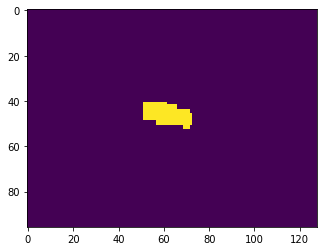

In [10]:
%matplotlib inline
plt.imshow(Y_test[1][:,:,0])

## Form segmented images from one hot encoding

In [11]:
def one_hot_to_seg(img_lst_one_hot,n_classes):
    img_lst_new = []
    for one_hot_img in range(len(img_lst_one_hot)):
        img_new = np.copy(img_lst_one_hot[one_hot_img])
        for lbl in range(0,n_classes):
            img_new[:,:,lbl]*=lbl*255/n_classes
        img_lst_new.append(np.sum(img_new,axis=2))
    return img_lst_new

In [12]:
Y_test_disp = one_hot_to_seg(Y_test,n_classes=n_classes)

# MultiResUNet Model

## Model Definition

The MultiResUNet model as described in the [paper](https://arxiv.org/abs/1902.04049) can be found  [here](https://github.com/nibtehaz/MultiResUNet/blob/master/MultiResUNet.py)

In [13]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 2, 1, 1, activation='sigmoid') # CHANGE FOR NUM CLASSES
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


## Auxiliary Functions

### Custom Metrics

Since Keras does not have build-in support for computing Dice Coefficient or Jaccard Index (at the time of writing), the following functions are declared

In [14]:
# def dice_coef(y_true, y_pred):
#     smooth = 0.0
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

### Saving Model 

Function to save the model

In [15]:
def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('models_dental')
    except:
        pass
    
    fp = open('models_dental/modelP.json','w')
    fp.write(model_json)
    model.save_weights('models_dental/modelW.h5')


### Evaluate the Model

We evaluate the model on test data (X_test, Y_test). 

We compute the values of Jaccard Index and Dice Coeficient, and save the predicted segmentation of first 10 images. The best model is also saved

(This could have been done using keras call-backs as well)

In [16]:
def evaluateModel(model, X_test, Y_test, batchSize):
    
    try:
        os.makedirs('results')
    except:
        pass 
    

    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)

    yp = np.round(yp,0)
    
    yp_disp = one_hot_to_seg(yp, 2) # CHANGE FOR N CLASSES

    for i in range(1):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(X_test[i],axis=2))
        plt.title('Input')
        plt.subplot(1,3,2)
        #TODO: show segmented Y
        plt.imshow(Y_test_disp[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp_disp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))  
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()


    jacard = 0
    dice = 0
    
    
    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    
    jacard /= len(Y_test)
    dice /= len(Y_test)
    


    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    

    fp = open('models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        fp = open('models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)


### Training the Model

The model is trained and evaluated after each epochs

In [17]:
def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):

    
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=2, verbose=1)     

        evaluateModel(model, X_test, Y_test,batchSize)

    return model 

## Define Model, Train and Evaluate

In [29]:
model = MultiResUnet(height=96, width=128, n_channels=1)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'categorical_accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[jacard, 'categorical_accuracy'])

saveModel(model)

fp = open('models/log.txt','w')
fp.close()
fp = open('models/best.txt','w')
fp.write('-1.0')
fp.close()
    
trainStep(model, X_train, Y_train, X_test, Y_test, epochs=3, batchSize=10)
# trainStep(model, X_train, Y_train, X_test, Y_test, epochs=2, batchSize=3)

Epoch : 1
Epoch 1/2
40/40 [==============================] - ETA: 47s - loss: 0.6931 - jacard: 0.3333 - categorical_accuracy: 0.02 - ETA: 16s - loss: 0.6929 - jacard: 0.3334 - categorical_accuracy: 0.50 - ETA: 5s - loss: 0.6927 - jacard: 0.3335 - categorical_accuracy: 0.6612 - 16s 411ms/step - loss: 0.6924 - jacard: 0.3337 - categorical_accuracy: 0.7401
Epoch 2/2
10/10 [==============================] - 2s 178ms/step
Jacard Index : 0.5
Dice Coefficient : 0.6666666666666667
***********************************************
Jacard Index improved from -1.0 to 0.5
***********************************************
Epoch : 2
Epoch 1/2
40/40 [==============================] - ETA: 0s - loss: 0.6893 - jacard: 0.3350 - categorical_accuracy: 0.982 - ETA: 0s - loss: 0.6891 - jacard: 0.3351 - categorical_accuracy: 0.979 - ETA: 0s - loss: 0.6888 - jacard: 0.3353 - categorical_accuracy: 0.979 - 1s 18ms/step - loss: 0.6886 - jacard: 0.3354 - categorical_accuracy: 0.9786
Epoch 2/2
10/10 [=================

In [19]:
np.squeeze(X_test[0],axis=2)

array([[0.45098039, 0.45098039, 0.45098039, ..., 0.01960784, 0.01960784,
        0.        ],
       [0.45098039, 0.45098039, 0.45098039, ..., 0.02352941, 0.01960784,
        0.        ],
       [0.45490196, 0.45490196, 0.45098039, ..., 0.02352941, 0.02352941,
        0.        ],
       ...,
       [0.24313725, 0.24313725, 0.42352941, ..., 0.05098039, 0.04705882,
        0.04705882],
       [0.21568627, 0.21960784, 0.41568627, ..., 0.05098039, 0.05098039,
        0.04705882],
       [0.21176471, 0.21176471, 0.41568627, ..., 0.05098039, 0.05098039,
        0.04705882]])

## Save as h5 model

In [20]:
# note: ONNX does not work -> errors with converting to onnx 14 and below (which matlab uses)
# instead use matlab to read in h5 file
model.save('model_h5_dental.h5')

In [21]:
!pip install numpy==1.21.5 --force-reinstall

ERROR: Could not find a version that satisfies the requirement numpy==1.21.5 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5)
ERROR: No matching distribution found for numpy==1.21.5


In [22]:
model_json = model.to_json()
fp = open('models\modelP_dental.json','w')
fp.write(model_json)
fp.close()

In [23]:
import json
with open("models\modelP_dental2.json", "w") as f:
    json.dump(json.loads(model_json), f, indent=4)

## Save Last Model Weights

In [24]:
# model = MultiResUnet(height=352, width=400, n_channels=1)
# !pip install 'h5py==2.9.0' --force-reinstall
model.save_weights("models\modelW_dental_last.h5")

## Try on training data for sanity check

40/40 [==============================] - ETA: 24 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 39ms/step


Text(0.5, 1.0, 'Prediction')

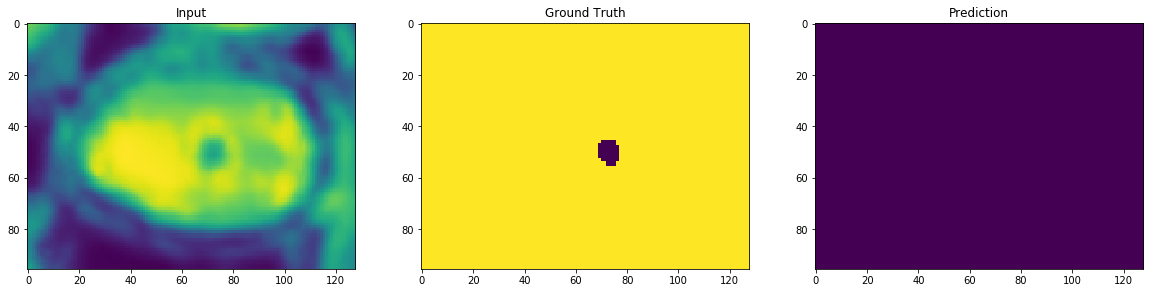

In [25]:
yp = model.predict(x=X_train, batch_size=1, verbose=1)
yp = np.round(yp,0)    
yp_disp = one_hot_to_seg(yp,n_classes=n_classes)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_train[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_train,n_classes)[0].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

In [26]:
yp[0].shape[0]

96

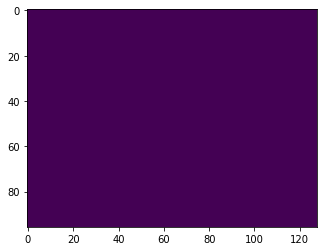

In [27]:
plt.imshow(yp[0][:,:,1])

## Try on One Image from Test Data

In [28]:
yp = model.predict(x=X_test, batch_size=1, verbose=1)
yp = np.round(yp,0)    
yp_disp = one_hot_to_seg(yp)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_test)[0].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

10/10 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 23ms/step


TypeError: one_hot_to_seg() missing 1 required positional argument: 'n_classes'

Text(0.5, 1.0, 'Prediction')

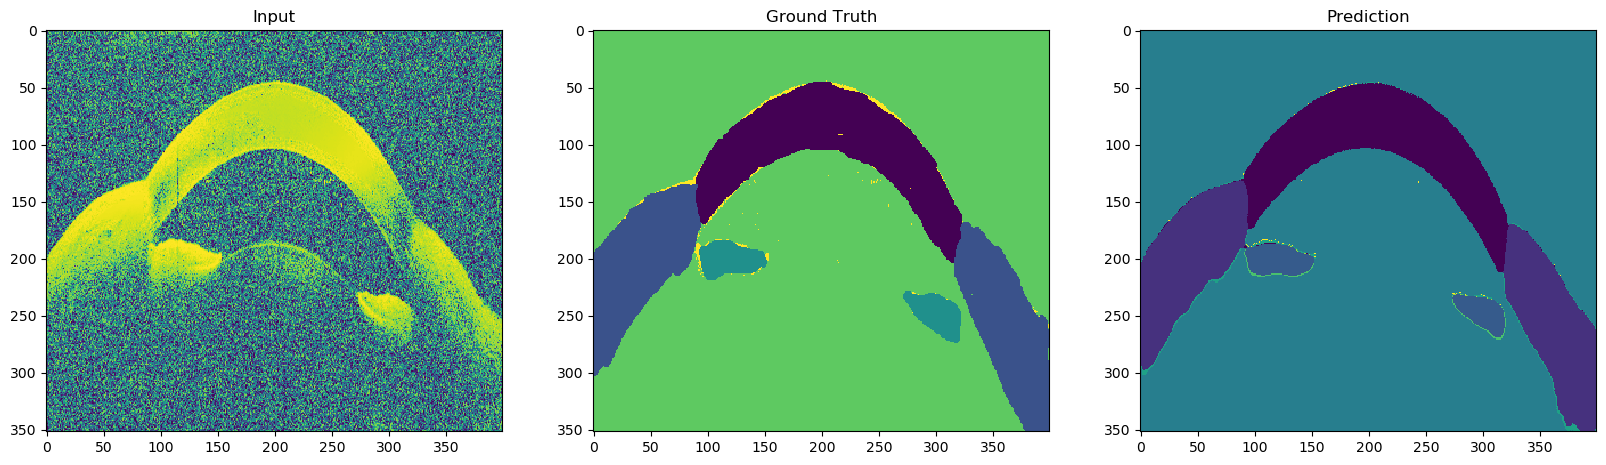

In [ ]:
img_no = 11

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test[img_no],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_test)[img_no].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[img_no].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

## Try on never seen test data

### Preprocess Part 1

In [ ]:
X_test_test = []
Y_test_test = []

img = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)

#         print('E:\YKL\Thorlabs VSCAN Labeling\scan30\{}'.format(img_fl))
resized_img = cv2.equalizeHist(np.clip(cv2.resize(img,(400, 352), interpolation = cv2.INTER_NEAREST),0,255))
resized_denoised_img = cv2.fastNlMeansDenoising(resized_img,10,7,21)

X_test_test.append(resized_denoised_img)

msk = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)
resized_msk = np.clip(cv2.resize(msk,(400, 352), interpolation = cv2.INTER_NEAREST),0,4)

# additional post processing for one hot encoding mask
resized_msk[resized_msk==0] = 6;
resized_msk_one_hot = np.zeros((resized_msk.shape[0], resized_msk.shape[1], n_classes))
for i, unique_value in enumerate(np.unique(resized_msk)):
    resized_msk_one_hot[:, :, i][resized_msk == unique_value] = 1

Y_test_test.append(resized_msk_one_hot)

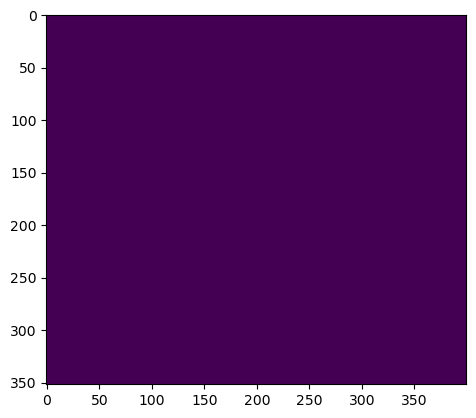

In [ ]:
plt.imshow(Y_test_test[0][:,:,2])

### Preprocess part 2

In [ ]:
X_test_test = np.array(X_test_test)
X_test_test = X_test_test[:, :, :, np.newaxis]
X_test_test = X_test_test / 255

### Prediction

In [ ]:
yp_test = model.predict(x=X_test_test, batch_size=1, verbose=1)
yp_test = np.round(yp_test,0)    
yp_test_disp = one_hot_to_seg(yp_test)

1/1 [==============================] - 7s 7s/step


### Show result

Text(0.5, 1.0, 'Prediction')

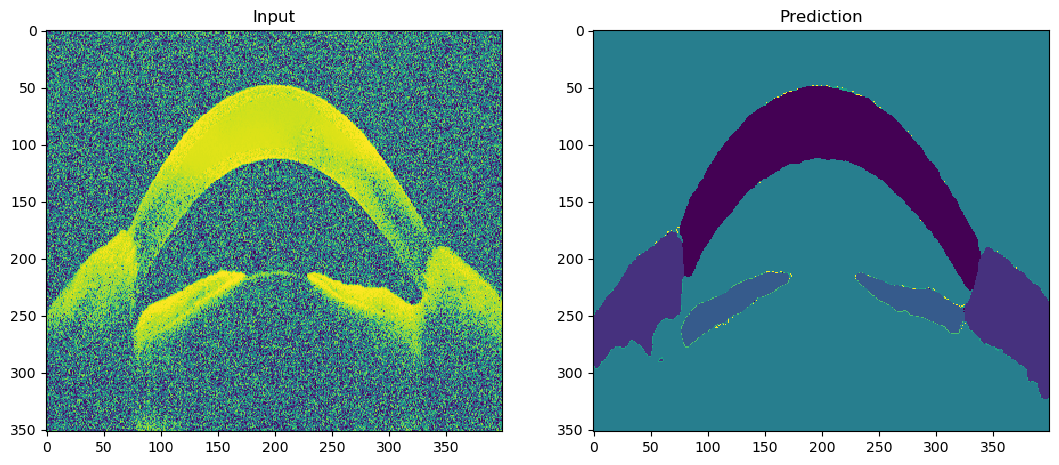

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test_test[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow(yp_test_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')